In [122]:
import numpy as np
from skimage import io
import napari
import pandas as pd
import zarr
import os
import pickle
import matplotlib.pyplot as plt 
import cv2
from cellpose import models
import tiffile as tf
import glob

### Make data for training
Assume training data is double color. One for the channel to get segmented and another for cytosol/nuclei.

In [113]:
# image path
fix_n5_path = '/mnt/aperto/fused/fused.n5' # zarr with pyramid resolution
# save path
#create the directory if it does not exist
directory = '/mnt/aperto/yin/crops/'
if not os.path.exists(directory):
    os.makedirs(directory)
    print("Directory created:", directory)
save_path = '/mnt/aperto/yin/crops'
# metadata path
meta_path = '/mnt/aperto/yin/info.pkl'

# create Zarr file object
fix_zarr = zarr.open(store=zarr.N5Store(fix_n5_path), mode='r')
# if you use ngff ome.zarr
# mov_zarr_path = '/mnt/ampa02_data01/tmurakami/240417_whole_4color_1st_M037-3pb/registration/round02.zarr'
# mov_zarr = zarr.open(mov_zarr_path, mode='r')

n5_setups = list(fix_zarr.keys())

voxel_size = (2.0,1.3,1.3)

Directory created: /mnt/aperto/yin/crops/


/tmp/ipykernel_7864/2796374053.py:14: FutureWarning: The N5Store is deprecated and will be removed in a Zarr-Python version 3, see https://github.com/zarr-developers/zarr-python/issues/1274 for more information.
  fix_zarr = zarr.open(store=zarr.N5Store(fix_n5_path), mode='r')


In [15]:
# set your parameters here
reference_chan = 3 # Integer or None
segment_chan = 4

# [100,256,256] crop size and FoV [100,768,768] are recommended for the 2D annotation
crop_size = [100,256,256]
FoV = [100,768,768]

# set corner positions. I suggest finding the positions using BigDataViewer or relevant.
# use the fourth column to add information
center_positions = [
    [1235,2510,775, 1],
    [1325,3350,1542,2],
    [1725,4632,1602]
]

corner_positions = [[(i-j//2) for i,j in zip(cent_pos, crop_size + [0])] for cent_pos in center_positions]

# set True for 2D annotation and set False for 3D annotation
select_plane = True

# processing of parameters
if not all([(j-i)>=0 for i,j in zip(crop_size, FoV)]):
    raise ValueError('FoV should be larger than crop_size')

In [16]:
corner_positions

[[1185, 2382, 647, 1], [1275, 3222, 1414, 2], [1675, 4504, 1474]]

In [17]:
# make metadata file if it does not exist.
if not os.path.exists(meta_path):
    df = pd.DataFrame(columns=['ID', 'integer_ID', 'instance_counts', 'corner', 'source', 'ref_channel', 'channel', 'crop_size', 'isHard', 'plane_position'])
else:
    df = pd.read_pickle(meta_path)


### Add cellpose annotate

#### load original data and get the image wan to label

In [219]:
with open('./annotation_position_info.pkl', 'rb') as f:
    ori_data = pickle.load(f)

In [220]:
# find all files in the directory ending with '_img.tif', and '_mask.tif' 
# you need to change this path to your image and mask file path
img_dir = '/mnt/aperto/yin/cellpose_training/data/image_masks/' 
img_files = sorted(glob.glob(f'{img_dir}*_img.tif'))
mask_files = sorted(glob.glob(f'{img_dir}*mask.tif'))
img_id = [item.split('/')[-1][:4] for item in img_files]

In [221]:
# check all the id are valid
for item in img_id:
    try:
        ori_data.iloc[int(item)]
    except:
       print(item, 'invalid id')

In [222]:
# example from original data frame
ori_data.head(5)

,ID,integer_ID,instance_counts,corner,source,ref_channel,channel,crop_size,select_plane,isHard,plane_position
0,0000,0,23,"[1061, 4601, 560]",/mnt/ampa02_data01/tmurakami/240417_whole_4col...,3,1,"[100, 256, 256]",True,0.0,24.0
1,0001,1,58,"[1325, 3350, 1543]",/mnt/ampa02_data01/tmurakami/240417_whole_4col...,3,1,"[100, 256, 256]",True,0.0,25.0
2,0002,2,5,"[1356, 517, 1669]",/mnt/ampa02_data01/tmurakami/240417_whole_4col...,3,1,"[100, 256, 256]",True,0.0,52.0
3,0003,3,7,"[1354, 566, 3633]",/mnt/ampa02_data01/tmurakami/240417_whole_4col...,3,1,"[100, 256, 256]",True,0.0,42.0
4,0004,4,27,"[1331, 2013, 706]",/mnt/ampa02_data01/tmurakami/240417_whole_4col...,3,1,"[100, 256, 256]",True,0.0,60.0


#### load cellpose prediction

In [223]:
# you need to change path to your pkl path
with open('/mnt/aperto/yin/cellpose_training/cellpose_nonorm_all.pkl', 'rb') as f:
    nonorm_data = pickle.load(f)

#print(f"loading file: {nonorm_data}")

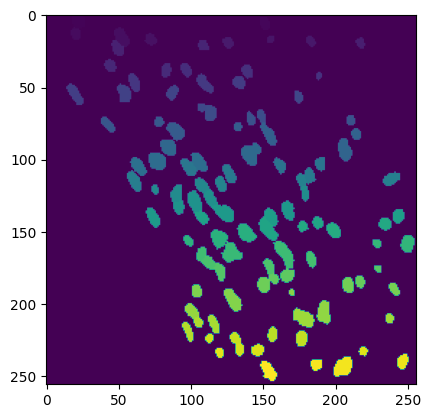

In [224]:
# exampld of cellpose prediction
plt.imshow(nonorm_data['0172'])

#### load all masks outlines

In [225]:
with open('/mnt/aperto/hzhao/image_outlines.pkl', 'rb') as f:
    outline_data = pickle.load(f)

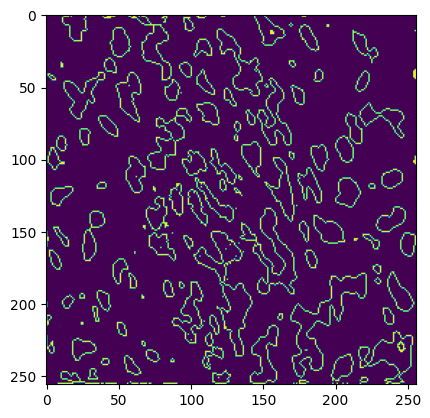

In [226]:
plt.imshow(outline_data['0172'])

In [227]:
outline_data['0172'].shape

(256, 256)

In [246]:
for ori_id in img_id:
    ori_id  = '0009'
    ori_corner_position = [ori_data['corner'][int(ori_id)]]
    ori_plane = int(ori_data['plane_position'][int(ori_id)])
    segment_chan = int(ori_data['channel'][int(ori_id)])
    reference_chan =  int(ori_data['ref_channel'][int(ori_id)])
    #you can check whether it can get them correctly
    #print(corner_positions_orignal)
    #print(segment_chan,reference_chan)
    #print(segment_chan,reference_chan)
    #print(cellpose_predict.shape)

    ##########
    ## add cellpose prediction
    cellpose_predict = nonorm_data[ori_id]
    # expand cellpose_prediction to correct size
    # create a 256x256 array of zeros
    single_layer = np.zeros((768, 768))
    # stack this array 100 times along a new axis (axis=0)
    prediction_label_stack = np.stack([single_layer] * 100, axis=0)
    expanded_array = np.zeros((768, 768))
    # Calculate the starting indices to place the 256x256 array in the center
    start_index = (768 - 256) // 2
    # Place the 256x256 array in the center of the 768x768 array
    expanded_array[start_index:start_index+256, start_index:start_index+256] = cellpose_predict
    prediction_label_stack[ori_plane] = expanded_array
    prediction_label_stack = prediction_label_stack.astype(int)
    
    # verify the result
    # print(prediction_label_stack.shape)  
    # print(prediction_label_stack.dtype)  
    # plt.imshow(expanded_array)
    # break
    
    #########
    ## add outlines image
    outline_predict = outline_data[ori_id]
    # expand cellpose_prediction to correct size
    # create a 256x256 array of zeros
    single_layer = np.zeros((768, 768))
    # stack this array 100 times along a new axis (axis=0)
    outline_stack = np.stack([single_layer] * 100, axis=0)
    expanded_array = np.zeros((768, 768))
    # Calculate the starting indices to place the 256x256 array in the center
    start_index = (768 - 256) // 2
    # Place the 256x256 array in the center of the 768x768 array
    expanded_array[start_index:start_index+256, start_index:start_index+256] = outline_predict
    outline_stack[ori_plane] = expanded_array
    outline_stack = outline_stack.astype(int)
     # verify the result
    print(outline_stack.shape)  
    print(outline_stack.dtype)
    # plt.imshow(expanded_array)
    # break

    pos = ori_corner_position[0]
    if len(pos) <= 2:
        raise ValueError('The position should have length 3')
    elif len(pos) == 3:
        isHard = 0
    elif len(pos) == 4:
        isHard = pos[-1]
        pos = pos[:-1]
    else:
        raise ValueError('You have a wrong position format')
        
    print(f"The index {i} with the position {pos}")
    idx = int(ori_id)
    
    # find out any duplication between the current data and the metadata
    # if it is duplicated, ask 
    flag = False
    if df['corner'].isin([pos]).any():
        for k in df['integer_ID'][df['corner'].isin([pos])].to_list():
            if ((df.loc[k,'source'] == fix_n5_path) and 
                (df.loc[k,'ref_channel'] == reference_chan) and 
                (df.loc[k,'channel'] == segment_chan) and 
                (df.loc[k,'crop_size'] == crop_size) and
                (df.loc[k,'select_plane'] == select_plane)):
                flag = True
                idx = k
    
    if flag:
        ans = input("Do you want to re-analyze the data? y or n")
        if ans != 'y':
            continue
        
    # set file path to be saved for both image and mask
    prefix = str(idx)
    while len(prefix) < 4:
        prefix = '0' + prefix
    img_path = os.path.join(save_path, prefix+'_img.tif')
    mask_path = os.path.join(save_path, prefix+'_mask.tif')


    # get the image of a channel to be segmented
    FoV_stack = []
    img = fix_zarr[n5_setups[segment_chan]]['timepoint0']['s0']

    # set the corner of FoV in napari
    top_corner = tuple(i-(k-j)//2 for i,j,k in zip(pos, crop_size, FoV))
    bottom_corner = tuple(i+j+(k-j)//2 for i,j,k in zip(pos, crop_size, FoV))
    top_corner = tuple(j if j>=i else i for i,j in zip([0,0,0],top_corner))
    bottom_corner = tuple(j if j<=i else i for i,j in zip(img.shape,bottom_corner))
    print('################')
    print('larger corner')
    print(top_corner, bottom_corner)
  
    
    
    # prepare to make border lines
    top_border_corner = tuple((k-j)//2 for j,k in zip(crop_size, FoV))
    bottom_border_corner = tuple(j+(k-j)//2 for j,k in zip(crop_size, FoV))
    
    FoV_segment = img[tuple(slice(i,j) for i,j in zip(top_corner, bottom_corner))]


    print('################')
    print('boarder line')
    print(top_border_corner,bottom_border_corner)
    print('Fov length: ', len(FoV_segment))
    print('FoV_seg {FoV_segment[100]}',  FoV_segment[0])
    #plt.imshow(FoV_segment[1])
    
    # get the image of a reference of channel
    if reference_chan is not None:
        img = fix_zarr[n5_setups[reference_chan]]['timepoint0']['s0']
        FoV_reference = img[tuple(slice(i,j) for i,j in zip(top_corner, bottom_corner))]
        FoV_stack.append(FoV_reference)
    
    FoV_stack.append(FoV_segment)
    FoV_stack = np.stack(FoV_stack)

    ##### FoV is a 2channel(reference and signal) Field of view


    print('###############')
    print('channel')
    print('ref(0) ',reference_chan)
    print('seg(1) ', segment_chan)
    # open Napari. Pause for loop until close the window
    viewer = napari.Viewer()
    #viewer.dims.current_step = ori_plane
    viewer.add_image(FoV_stack, channel_axis=0, scale=voxel_size, contrast_limits=[0,65535])
    viewer.add_shapes([[bottom_border_corner[1]*voxel_size[1],bottom_border_corner[2]*voxel_size[2]],[top_border_corner[1]*voxel_size[1],bottom_border_corner[2]*voxel_size[2]]],
                      edge_width=2,edge_color='white',ndim=2,shape_type='line')
    viewer.add_shapes([[top_border_corner[1]*voxel_size[1],bottom_border_corner[2]*voxel_size[2]],[top_border_corner[1]*voxel_size[1],top_border_corner[2]*voxel_size[2]]],
                  edge_width=2,edge_color='white',ndim=2,shape_type='line')
    viewer.add_shapes([[bottom_border_corner[1]*voxel_size[1],bottom_border_corner[2]*voxel_size[2]],[bottom_border_corner[1]*voxel_size[1],top_border_corner[2]*voxel_size[2]]],
                  edge_width=2,edge_color='white',ndim=2,shape_type='line')
    viewer.add_shapes([[bottom_border_corner[1]*voxel_size[1],top_border_corner[2]*voxel_size[2]],[top_border_corner[1]*voxel_size[1],top_border_corner[2]*voxel_size[2]]],
                  edge_width=2,edge_color='white',ndim=2,shape_type='line')
    labels = viewer.add_labels(np.zeros_like(FoV_segment), name='segmentation', scale=voxel_size)
    labels_cellpose = viewer.add_labels(prediction_label_stack,  name=f'cellpose({ori_plane})', scale=voxel_size)
    labels_outline = viewer.add_labels(outline_stack,  name=f'outline({ori_plane})', scale=voxel_size)
    #viewer.add_image(outline_stack, scale=voxel_size, contrast_limits=[0,65535])
    
    ##### input model prediction as numpy here
        # Load your saved model

    viewer.show(block=True)
    
    sub_area_slicer = tuple(slice(i,j) for i,j in zip(top_border_corner,bottom_border_corner))
    ######
    # subarea shape
    # save images and segmentation.
    img = np.swapaxes(FoV_stack[(slice(0,None),)+sub_area_slicer],0,1)
    ######
    # modify this to cellpose label
    #labels_img = labels.data[sub_area_slicer]
    labels_img = labels_cellpose.data[sub_area_slicer]
    
    if select_plane:
        print('#############')
        print('selected and save')
        ##########
        # modify this to original label
        plane_pos = np.argmax((labels_cellpose.data>0).sum(axis=(1,2)))
        img = img[plane_pos,...]
        labels_img = labels_img[plane_pos,...]
        io.imsave(img_path, img, plugin='tifffile', imagej=True, metadata={'axes': 'CYX'})
        io.imsave(mask_path, labels_img, plugin='tifffile')

    else:
        print('#############')
        print('not selected and save')
        io.imsave(img_path, img, plugin='tifffile', imagej=True, metadata={'axes': 'ZCYX'})
        io.imsave(mask_path, labels_img, plugin='tifffile')

    # update the metadata
    df.loc[idx,'ID'] = prefix
    df.loc[idx,'integer_ID'] = idx
    count = (np.unique(labels_img)).size - 1
    df.loc[idx,'instance_counts'] = count
    df.at[idx,'corner'] = pos
    df.loc[idx, 'source'] = fix_n5_path
    df.loc[idx, 'ref_channel'] = reference_chan
    df.loc[idx, 'channel'] = segment_chan
    df.at[idx, 'crop_size'] = crop_size
    df.loc[idx, 'select_plane'] = select_plane
    df.loc[idx, 'isHard'] = isHard
    if select_plane:
        df.loc[idx, 'plane_position'] = int(plane_pos)
    else:
        df.loc[idx, 'plane_position'] = -1

# pickle the metadata
###### maybe need to change to new meta path
df.to_pickle(meta_path)
    

(100, 768, 768)
int64
The index 0 with the position [1207, 1266, 4353]
################
larger corner
(1207, 1010, 4097) (1307, 1778, 4865)
################
boarder line
(0, 256, 256) (100, 512, 512)
Fov length:  100
FoV_seg {FoV_segment[100]} [[259 240 257 ... 194 174 213]
 [254 259 243 ... 199 181 210]
 [255 265 265 ... 191 178 206]
 ...
 [215 255 236 ... 238 260 250]
 [216 232 244 ... 244 252 248]
 [204 251 220 ... 246 270 264]]
###############
channel
ref(0)  3
seg(1)  1
#############
selected and save


/tmp/ipykernel_7864/864099188.py:182: UserWarning: /mnt/aperto/yin/crops/0009_mask.tif is a low contrast image
  io.imsave(mask_path, labels_img, plugin='tifffile')


(100, 768, 768)
int64
The index 0 with the position [1207, 1266, 4353]


KeyboardInterrupt: Interrupted by user

In [213]:
ori_plane

25

In [216]:
outline_stack[25,:,:]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

### Recover annotate

In [158]:
with open('./annotation_position_info.pkl', 'rb') as f:
    ori_data = pickle.load(f)

In [159]:
orignal_label_path = '/mnt/aperto/yin/cellpose_training/data/image_masks/0010_mask.tif'

In [160]:
original_id = int(orignal_label_path.split('/')[-1][:4])

In [161]:
ori_data.iloc[original_id]

ID                                                              0010
integer_ID                                                        10
instance_counts                                                    5
corner                                            [1207, 2997, 4567]
source             /mnt/ampa02_data01/tmurakami/240417_whole_4col...
ref_channel                                                        3
channel                                                            1
crop_size                                            [100, 256, 256]
select_plane                                                    True
isHard                                                           4.0
plane_position                                                  51.0
Name: 10, dtype: object

In [162]:
corner_positions_orignal = [ori_data['corner'][original_id]]

In [163]:
corner_positions_orignal

[[1207, 2997, 4567]]

In [164]:
#corner_positions_orignal[0][0]+= int(ori_data['plane_position'][172])

In [165]:
original_label = tf.imread(orignal_label_path)
original_label = np.array(original_label)
# Create a 256x256 array of zeros
single_layer = np.zeros((768, 768))
# Stack this array 100 times along a new axis (axis=0)
original_label_stack = np.stack([single_layer] * 100, axis=0)

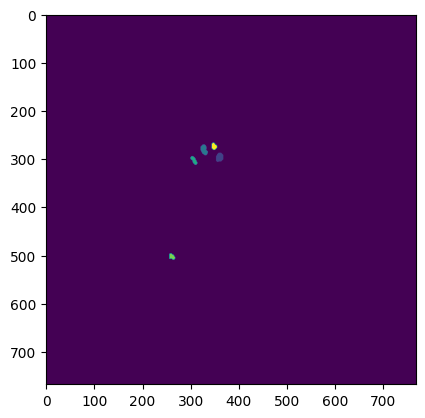

In [166]:
########
#expend original 256x256 => 768x768
# Create a 256x256 array (example with random values)
original_array = original_label
# Create a 768x768 array filled with zeros
expanded_array = np.zeros((768, 768))
# Calculate the starting indices to place the 256x256 array in the center
start_index = (768 - 256) // 2
# Place the 256x256 array in the center of the 768x768 array
expanded_array[start_index:start_index+256, start_index:start_index+256] = original_label
plt.imshow(expanded_array)

In [167]:
ori_plane = int(ori_data['plane_position'][original_id])

In [168]:
original_label_stack[ori_plane] = expanded_array

In [169]:
original_label_stack = original_label_stack.astype(int)

# Verify the result
print(original_label_stack.shape)  
print(original_label_stack.dtype)  


(100, 768, 768)
int64


In [170]:
segment_chan = int(ori_data['channel'][original_id])

In [171]:
segment_chan

1

In [172]:
#corner_positions_orignal = [[1207, 2997+256, 4567+256]]

In [173]:
corner_positions_orignal

[[1207, 2997, 4567]]

In [237]:
for i, pos in enumerate(corner_positions_orignal):
    
    if len(pos) <= 2:
        raise ValueError('The position should have length 3')
    elif len(pos) == 3:
        isHard = 0
    elif len(pos) == 4:
        isHard = pos[-1]
        pos = pos[:-1]
    else:
        raise ValueError('You have a wrong position format')
        
    print(f"The index {i} with the position {pos}")
    #######
    # change this idx to id
    #idx = len(df)
    idx = original_id
    
    # find out any duplication between the current data and the metadata
    # if it is duplicated, ask 
    flag = False
    if df['corner'].isin([pos]).any():
        for k in df['integer_ID'][df['corner'].isin([pos])].to_list():
            if ((df.loc[k,'source'] == fix_n5_path) and 
                (df.loc[k,'ref_channel'] == reference_chan) and 
                (df.loc[k,'channel'] == segment_chan) and 
                (df.loc[k,'crop_size'] == crop_size) and
                (df.loc[k,'select_plane'] == select_plane)):
                flag = True
                idx = k
    
    if flag:
        ans = input("Do you want to re-analyze the data? y or n")
        if ans != 'y':
            continue
        
    # set file path to be saved for both image and mask
    prefix = str(idx)
    while len(prefix) < 4:
        prefix = '0' + prefix
    img_path = os.path.join(save_path, prefix+'_img.tif')
    mask_path = os.path.join(save_path, prefix+'_mask.tif')


    # get the image of a channel to be segmented
    FoV_stack = []
    img = fix_zarr[n5_setups[segment_chan]]['timepoint0']['s0']

    # set the corner of FoV in napari
    top_corner = tuple(i-(k-j)//2 for i,j,k in zip(pos, crop_size, FoV))
    bottom_corner = tuple(i+j+(k-j)//2 for i,j,k in zip(pos, crop_size, FoV))
    top_corner = tuple(j if j>=i else i for i,j in zip([0,0,0],top_corner))
    bottom_corner = tuple(j if j<=i else i for i,j in zip(img.shape,bottom_corner))
    print('################')
    print('larger corner')
    print(top_corner, bottom_corner)
  
    
    
    # prepare to make border lines
    top_border_corner = tuple((k-j)//2 for j,k in zip(crop_size, FoV))
    bottom_border_corner = tuple(j+(k-j)//2 for j,k in zip(crop_size, FoV))
    
    FoV_segment = img[tuple(slice(i,j) for i,j in zip(top_corner, bottom_corner))]


    print('################')
    print('boarder line')
    print(top_border_corner,bottom_border_corner)
    print('Fov length: ', len(FoV_segment))
    print('FoV_seg {FoV_segment[100]}',  FoV_segment[0])
    #plt.imshow(FoV_segment[1])
    
    # get the image of a reference of channel
    if reference_chan is not None:
        img = fix_zarr[n5_setups[reference_chan]]['timepoint0']['s0']
        FoV_reference = img[tuple(slice(i,j) for i,j in zip(top_corner, bottom_corner))]
        FoV_stack.append(FoV_reference)
    
    FoV_stack.append(FoV_segment)
    FoV_stack = np.stack(FoV_stack)
    #plt.imshow(FoV_stack[0][1])
    #plt.imshow(FoV_stack[1][1])

    ##### FoV is a 2channel(reference and signal) Field of view


    print('###############')
    print('channel')
    print('ref(0) ',reference_chan)
    print('seg(1) ', segment_chan)
    # open Napari. Pause for loop until close the window
    viewer = napari.Viewer()
    viewer.add_image(FoV_stack, channel_axis=0, scale=voxel_size, contrast_limits=[0,65535])
    viewer.add_shapes([[bottom_border_corner[1]*voxel_size[1],bottom_border_corner[2]*voxel_size[2]],[top_border_corner[1]*voxel_size[1],bottom_border_corner[2]*voxel_size[2]]],
                      edge_width=2,edge_color='white',ndim=2,shape_type='line')
    viewer.add_shapes([[top_border_corner[1]*voxel_size[1],bottom_border_corner[2]*voxel_size[2]],[top_border_corner[1]*voxel_size[1],top_border_corner[2]*voxel_size[2]]],
                  edge_width=2,edge_color='white',ndim=2,shape_type='line')
    viewer.add_shapes([[bottom_border_corner[1]*voxel_size[1],bottom_border_corner[2]*voxel_size[2]],[bottom_border_corner[1]*voxel_size[1],top_border_corner[2]*voxel_size[2]]],
                  edge_width=2,edge_color='white',ndim=2,shape_type='line')
    viewer.add_shapes([[bottom_border_corner[1]*voxel_size[1],top_border_corner[2]*voxel_size[2]],[top_border_corner[1]*voxel_size[1],top_border_corner[2]*voxel_size[2]]],
                  edge_width=2,edge_color='white',ndim=2,shape_type='line')
    labels = viewer.add_labels(np.zeros_like(FoV_segment), name='segmentation', scale=voxel_size)
    labels_original = viewer.add_labels(original_label_stack,  name=f'original({ori_plane})', scale=voxel_size)
    
    ##### input model prediction as numpy here
        # Load your saved model

    viewer.show(block=True)
    
    sub_area_slicer = tuple(slice(i,j) for i,j in zip(top_border_corner,bottom_border_corner))
    ######
    # subarea shape
    # save images and segmentation.
    img = np.swapaxes(FoV_stack[(slice(0,None),)+sub_area_slicer],0,1)
    ######
    # modify this to original label
    #labels_img = labels.data[sub_area_slicer]
    labels_img = labels_original.data[sub_area_slicer]
    
    if select_plane:
        print('#############')
        print('selected and save')
        ##########
        # modify this to original label
        plane_pos = np.argmax((labels_original.data>0).sum(axis=(1,2)))
        img = img[plane_pos,...]
        labels_img = labels_img[plane_pos,...]
        io.imsave(img_path, img, plugin='tifffile', imagej=True, metadata={'axes': 'CYX'})
        io.imsave(mask_path, labels_img, plugin='tifffile')

    else:
        print('#############')
        print('not selected and save')
        io.imsave(img_path, img, plugin='tifffile', imagej=True, metadata={'axes': 'ZCYX'})
        io.imsave(mask_path, labels_img, plugin='tifffile')

    # update the metadata
    df.loc[idx,'ID'] = prefix
    df.loc[idx,'integer_ID'] = idx
    count = (np.unique(labels_img)).size - 1
    df.loc[idx,'instance_counts'] = count
    df.at[idx,'corner'] = pos
    df.loc[idx, 'source'] = fix_n5_path
    df.loc[idx, 'ref_channel'] = reference_chan
    df.loc[idx, 'channel'] = segment_chan
    df.at[idx, 'crop_size'] = crop_size
    df.loc[idx, 'select_plane'] = select_plane
    df.loc[idx, 'isHard'] = isHard
    if select_plane:
        df.loc[idx, 'plane_position'] = int(plane_pos)
    else:
        df.loc[idx, 'plane_position'] = -1

# pickle the metadata
df.to_pickle(meta_path)

The index 0 with the position [1207, 2997, 4567]
################
larger corner
(1207, 2741, 4311) (1307, 3509, 5079)
################
boarder line
(0, 256, 256) (100, 512, 512)
Fov length:  100
FoV_seg {FoV_segment[100]} [[123 115 118 ... 141 139 138]
 [109 117 114 ... 134 136 137]
 [114 120 120 ... 136 138 137]
 ...
 [153 153 147 ... 144 141 128]
 [158 159 156 ... 155 143 137]
 [162 173 157 ... 156 147 141]]
###############
channel
ref(0)  3
seg(1)  4
#############
selected and save


/tmp/ipykernel_7864/274419765.py:129: UserWarning: /mnt/aperto/yin/crops/0010_img.tif is a low contrast image
  io.imsave(img_path, img, plugin='tifffile', imagej=True, metadata={'axes': 'CYX'})
/tmp/ipykernel_7864/274419765.py:130: UserWarning: /mnt/aperto/yin/crops/0010_mask.tif is a low contrast image
  io.imsave(mask_path, labels_img, plugin='tifffile')


In [108]:
plane_pos

51

In [260]:
n5_setups[1]

'setup1'

In [258]:
img = fix_zarr[n5_setups[1]]['timepoint0']['s0']

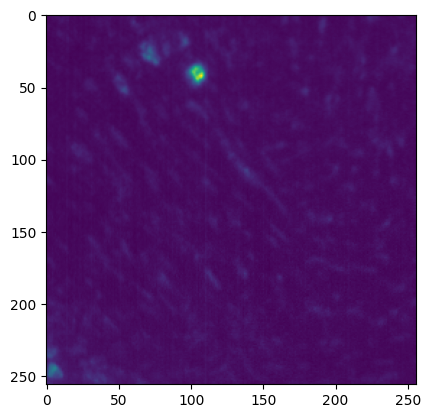

In [259]:
plt.imshow(img[1207 + 51, 2997: 2997 + 256, 4567: 4567 + 256])

In [268]:
ori_data.iloc[172]

ID                                                              0172
integer_ID                                                       172
instance_counts                                                  139
corner                                            [1404, 3356, 4747]
source             /mnt/ampa02_data01/tmurakami/240425_whole_4col...
ref_channel                                                        3
channel                                                            4
crop_size                                            [100, 256, 256]
select_plane                                                    True
isHard                                                           0.0
plane_position                                                  49.0
Name: 172, dtype: object

In [269]:
ori_data.iloc[100]

ID                                                              0100
integer_ID                                                       100
instance_counts                                                   13
corner                                             [445, 4047, 2437]
source             /mnt/ampa02_data01/tmurakami/240417_whole_4col...
ref_channel                                                        3
channel                                                            4
crop_size                                            [100, 256, 256]
select_plane                                                    True
isHard                                                           0.0
plane_position                                                  49.0
Name: 100, dtype: object

In [271]:
ori_data.iloc[200]

ID                                                              0200
integer_ID                                                       200
instance_counts                                                   81
corner                                            [1345, 1832, 5347]
source             /mnt/ampa02_data01/tmurakami/240425_whole_4col...
ref_channel                                                        3
channel                                                            2
crop_size                                            [100, 256, 256]
select_plane                                                    True
isHard                                                           0.0
plane_position                                                  32.0
Name: 200, dtype: object

## Debugging

#### Check recover img and mask are the same

In [115]:
oirginal_img = tf.imread('/mnt/aperto/yin/cellpose_training/data/image_masks/0010_img.tif')
crop_img = tf.imread('/mnt/aperto/yin/crops/0010_img.tif')

is same?  True
is same?  True


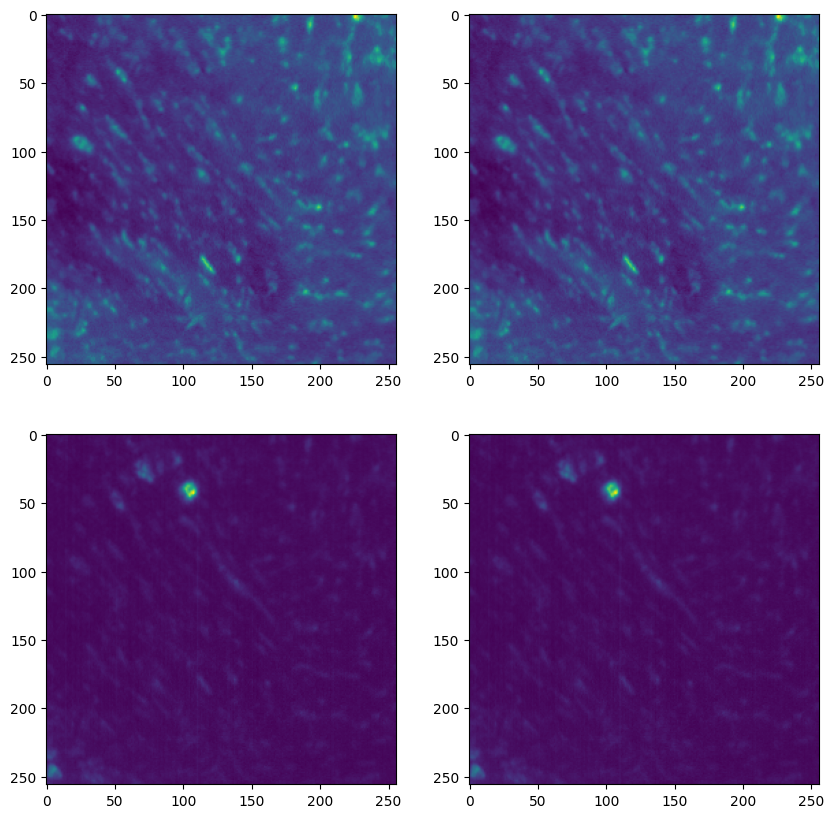

In [116]:
fig, ax = plt.subplots(2,2, figsize = (10,10))
ax[0][0].imshow(oirginal_img[0])
ax[0][1].imshow(crop_img[0])
ax[1][0].imshow(oirginal_img[1])
ax[1][1].imshow(crop_img[1])
print('is same? ', np.sum(np.equal(oirginal_img[0],crop_img[0]))== 65536)
print('is same? ', np.sum(np.equal(oirginal_img[1],crop_img[1]))== 65536)

In [118]:
oirginal_mask = tf.imread('/mnt/aperto/yin/cellpose_training/data/image_masks/0010_mask.tif')
crop_mask = tf.imread('/mnt/aperto/yin/crops/0010_mask.tif')

is same?  True


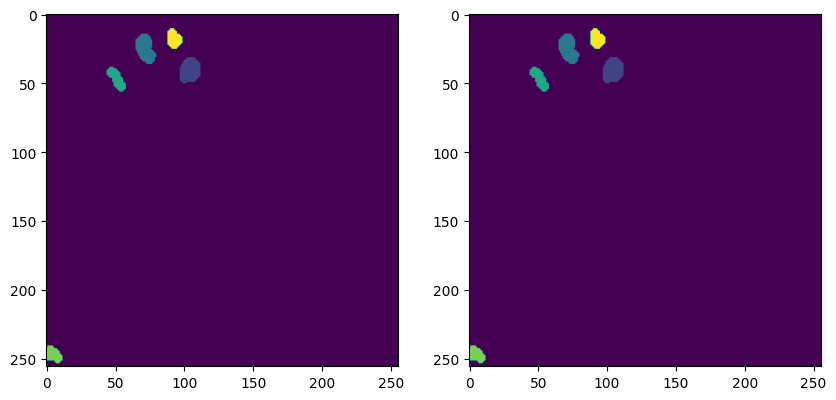

In [119]:
fig, ax = plt.subplots(1,2, figsize = (10,10))
ax[0].imshow(oirginal_mask)
ax[1].imshow(crop_mask)
print('is same? ', np.sum(np.equal(oirginal_mask,crop_mask))== 65536)

In [235]:
df = pd.read_pickle(meta_path)

In [236]:
df

,ID,integer_ID,instance_counts,corner,source,ref_channel,channel,crop_size,isHard,plane_position,select_plane
10,0010,10,5,"[1207, 2997, 4567]",/mnt/aperto/fused/fused.n5,3,1,"[100, 256, 256]",0,51,True
